# 1. Environment Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121



!pip install ultralytics -q
!pip install roboflow -q

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 852.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [2]:
import torch, ultralytics
print("Torch version:", torch.__version__)
print("Ultralytics version:", ultralytics.__version__)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch version: 2.4.0+cu121
Ultralytics version: 8.3.233


# 2. Import Libraries

In [3]:
import os
import cv2
import glob
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO
from roboflow import Roboflow
from PIL import Image
import shutil

# 3. Load Dataset

In [4]:
rf = Roboflow(api_key="PXdjogidaWyDpVU6sdJa")
project = rf.workspace("kpi-zitnq").project("landmines-vxldd")
version = project.version(5)

# Export format MUST MATCH model type (v8 → YOLOv8)
dataset = version.download("yolov8")

data_yaml = dataset.location + "/data.yaml"
print("Dataset loaded from:", data_yaml)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Landmines-5 in yolov8:: 100%|██████████| 2066/2066 [00:00<00:00, 6686.69it/s]

Dataset loaded from: /content/Landmines-5/data.yaml


# 4. Visualize Dataset Samples

Train: 689
Valid: 237
Test : 101


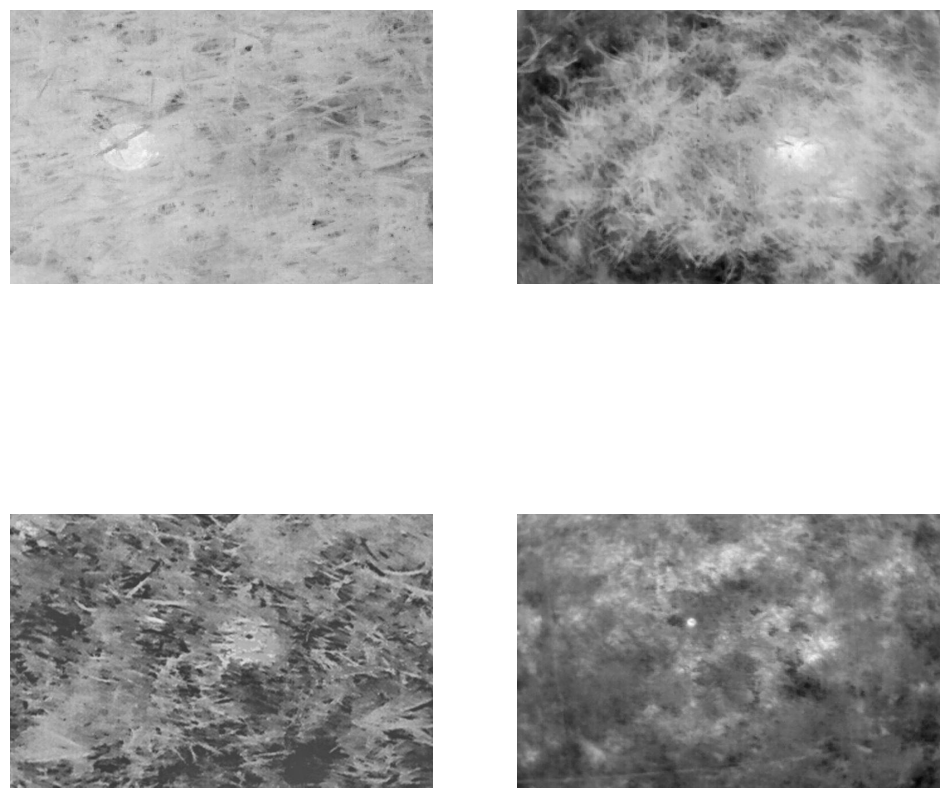

In [5]:
train_images = glob.glob(os.path.join(dataset.location, "train/images/*.jpg"))
val_images   = glob.glob(os.path.join(dataset.location, "valid/images/*.jpg"))
test_images  = glob.glob(os.path.join(dataset.location, "test/images/*.jpg"))

print(f"Train: {len(train_images)}")
print(f"Valid: {len(val_images)}")
print(f"Test : {len(test_images)}")

# Show 4 random training samples
plt.figure(figsize=(12, 12))
for i, p in enumerate(random.sample(train_images, 4)):
    plt.subplot(2, 2, i+1)
    plt.imshow(Image.open(p))
    plt.axis("off")
plt.show()

#5. Load Model

In [6]:
!wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8s.pt -O yolov8s.pt



--2025-11-30 16:34:42--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8s.pt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/f408390c-e756-4681-b520-75ddbbe07c42?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-30T17%3A23%3A15Z&rscd=attachment%3B+filename%3Dyolov8s.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-30T16%3A22%3A56Z&ske=2025-11-30T17%3A23%3A15Z&sks=b&skv=2018-11-09&sig=OB1Uja%2B2gI5fTtuMT%2BI61nblLLipJ1TldzR2CdKGQq4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDUyMjI4MiwibmJmIjoxNzY0NTIwNDgyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvc

In [7]:
model = YOLO("yolov8s.pt")

#6. Train Model

In [8]:
results = model.train(
    data=data_yaml,
    epochs=50,
    imgsz=640,
    batch=16,
    patience=20,
    optimizer="SGD",
    lr0=0.01,
    weight_decay=0.0005,
    mosaic=1.0,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=5,
    translate=0.1,
    scale=0.5
)

results

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Landmines-5/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b1f986f3800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#7. Validate Model Performance

In [9]:
metrics = model.val()
metrics

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1282.7±427.0 MB/s, size: 35.0 KB)
val: Scanning /content/Landmines-5/valid/labels.cache... 237 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 237/237 478.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.3it/s 3.5s
                   all        237        281      0.977      0.964      0.988      0.635
Speed: 2.4ms preprocess, 5.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b226c8b1490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#8. Test on Sample Images

Testing on: /content/Landmines-5/test/images/5_Zone_1_Mine_1cm_depth__2-2m_TemperatureInCenter__33-C_jpg.rf.94dcca373102acf10657071ac661716d.jpg

image 1/1 /content/Landmines-5/test/images/5_Zone_1_Mine_1cm_depth__2-2m_TemperatureInCenter__33-C_jpg.rf.94dcca373102acf10657071ac661716d.jpg: 416x640 1 landmines, 17.0ms
Speed: 7.4ms preprocess, 17.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


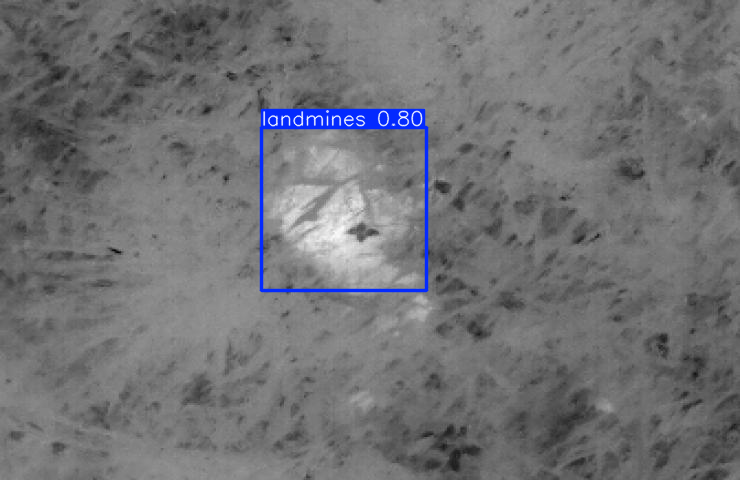

In [11]:
test_image = random.choice(test_images)
print("Testing on:", test_image)

results = model(test_image, conf=0.4)
results[0].show()

# 9. SAVE BEST WEIGHTS

In [12]:
src = "runs/detect/train/weights/best.pt"
dst = "/content/landmines_yolov8s_best.pt"

if os.path.exists(src):
    shutil.copy(src, dst)
    print("Saved:", dst)
else:
    print("ERROR: best.pt not found")

Saved: /content/landmines_yolov8s_best.pt


# 10. EXPORT MODEL (ONNX for Production)

In [13]:
model.export(format="onnx")
print("Exported to ONNX")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.4.0+cu121 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 194ms
Prepared 6 packages in 4.10s
Installed 6 packages in 367ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.77

requirements: AutoUpdate success ✅ 5.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.77...
ONNX